Set up environment and load in data

In [1]:
library(tidyverse)
library(here)
library(grid)
library(gridExtra)
theme_set(theme_bw())
helpers_path = paste0(here(),'/analysis/helpers/')
source(paste0(helpers_path, '01_clean_behavioral_data.R'))
rm(data_bc_clean)
fig_out_path = paste0(here(), '/outputs/fig/')

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /Users/zenkavi/Documents/RangelLab/NovelVsRepeated/behavior


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




[1] "Done loading data."
[1] "Resetting helpers path..."


**Make sure to scale value and exclude too fast trials before fitting**

In [2]:
normMax = 1
normMin = -1

data_yn_clean = data_yn_clean %>%
  filter(reference != -99) %>%
  filter(rt > .3 & rt < 5) %>% # discard very long and short RT trials
  group_by(subnum, day, type) %>%
  mutate(possiblePayoff_dmn = possiblePayoff - mean(possiblePayoff)) %>%
  mutate(rawVDiff = possiblePayoff - reference,
         normVDiff =  (normMax - normMin) / (max(rawVDiff) - min(rawVDiff)) * (rawVDiff - max(rawVDiff)) + (normMax) )

rm(normMax, normMin)

# Exploring priors and parameter space

What does a subject prior for drift rates look like in the HDDM (from Lombardi-Hare toolbox)

```
d.mu ~ dunif(.00001, 50)
d.pr ~ dgamma(1, .1)
d[subject] ~ dnorm(d.mu, d.pr) [trimmed at 10e-5, 50]

```

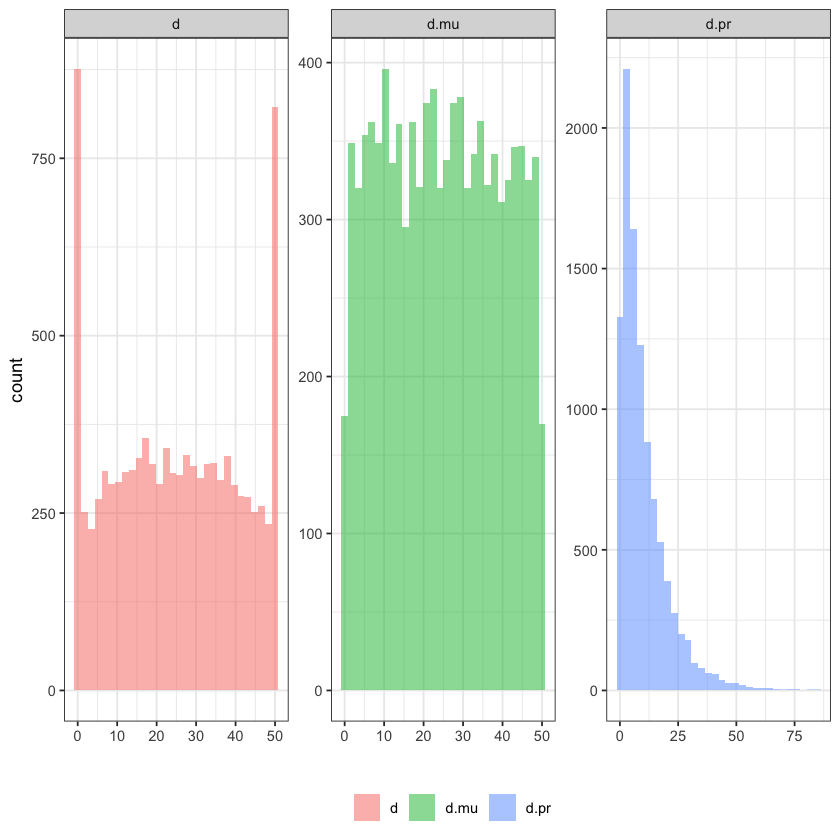

In [3]:
n = 10000

dat = data.frame(d.mu = runif(n, .00001, 50), d.pr = rgamma(n, 1, .1))

for(i in 1:nrow(dat)){
  dat$d[i] = rnorm(1, dat$d.mu[i], dat$d.pr[i])
}

dat$d = ifelse(dat$d > 50, 50, ifelse(dat$d<.000001, .000001, dat$d))

dat %>%
  # select(d) %>%
  gather(key, value) %>%
  # mutate(key = factor(key, levels = c("d.pr", "d.mu", "d"))) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")

What about the bias and ndt? Uniform-ish too.

```
bias[p] ~ dbeta(bias.alpha, bias.beta)T(0.01,0.99)

bias.alpha <- bias.mu * bias.kappa
bias.beta <- (1 - bias.mu) * bias.kappa
bias.mu ~ dbeta(2, 2)T(0.01,0.99)
bias.kappa ~ dgamma(1, 0.5)
```

**NOTE: This is operationalized in the HDDM, ranging from 0 to 1 and no bias is .5**

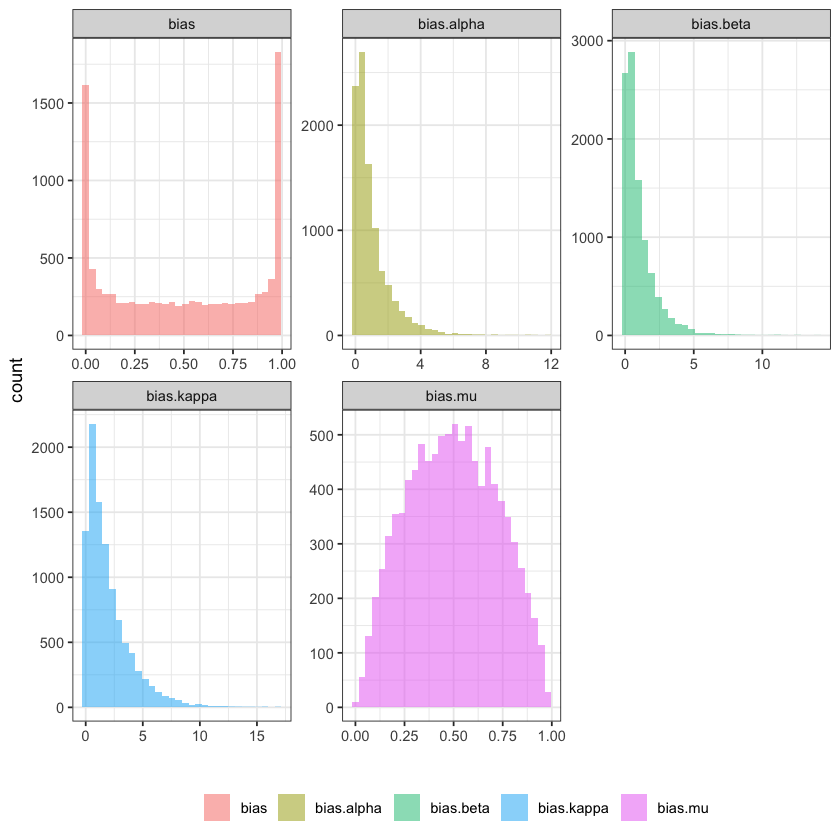

In [4]:
n = 10000

dat = data.frame(bias.kappa = rgamma(n, 1, .5), bias.mu = rbeta(n, 2, 2))

dat$bias.mu = ifelse(dat$bias.mu < .01, .01, ifelse(dat$bias.mu > .99, .99, dat$bias.mu))

dat = dat %>%
  mutate(bias.beta = (1 - bias.mu) * bias.kappa,
         bias.alpha = bias.mu * bias.kappa)

for(i in 1:nrow(dat)){
  dat$bias[i] = rbeta(1, dat$bias.alpha[i], dat$bias.beta[i])
}

dat$bias = ifelse(dat$bias < .01, .01, ifelse(dat$bias > .99, .99, dat$bias))

dat %>%
  gather(key, value) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")


```
theta.p[p] ~ dnorm(ndt.mu, ndt.pr)T(0.01, 1)
ndt.pr ~ dgamma(1, 0.1)
ndt.mu ~ dunif(0, 1)
```

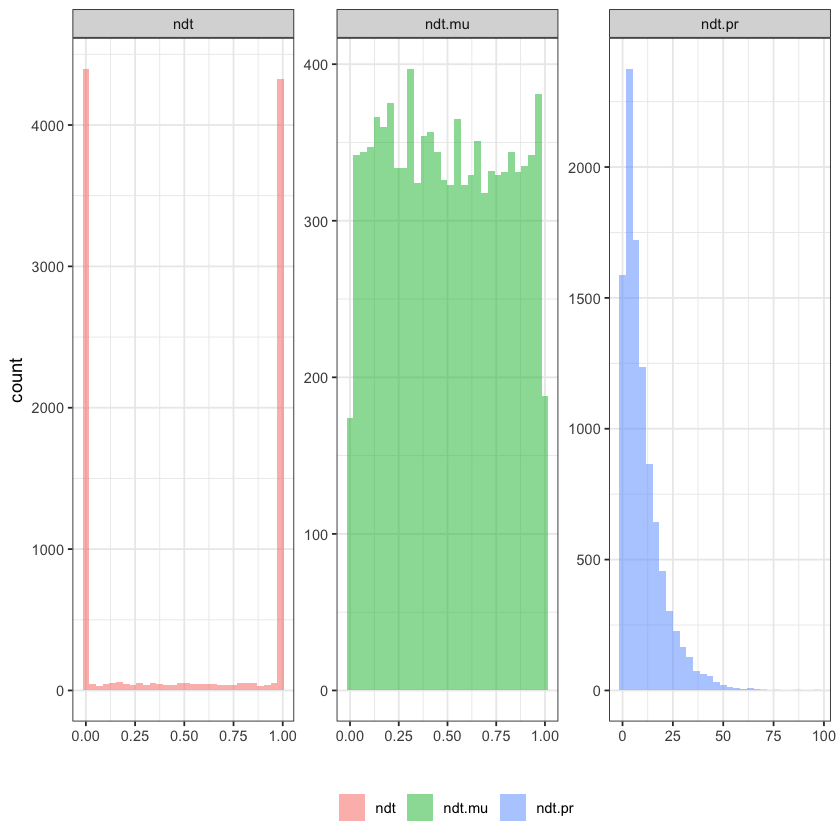

In [5]:
n = 10000

dat = data.frame(ndt.mu = runif(n, 0, 1), ndt.pr = rgamma(n, 1, .1))

for(i in 1:nrow(dat)){
  dat$ndt[i] = rnorm(1, dat$ndt.mu[i], dat$ndt.pr[i])
}

dat$ndt = ifelse(dat$ndt < .01, .01, ifelse(dat$ndt > 1, 1, dat$ndt))

dat %>%
  gather(key, value) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")


What are reasonable values for barrierDecay? Prior: Uniform[0, .01]; min = 0, max = 0.02

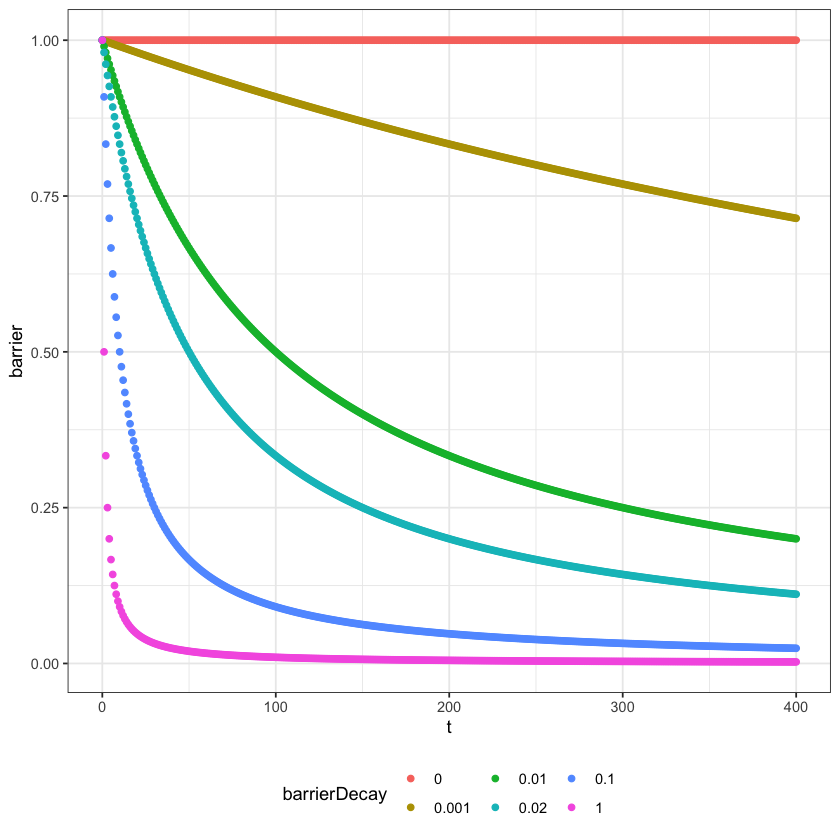

In [6]:
decay_vals = c(0, .001, .01, .02, .1, 1)

maxIter = 400

dat = data.frame()

for(cur_dv in decay_vals){
  cur_dat = data.frame(t = c(0:maxIter),
                       initialBarrier = 1, 
                       barrierDecay = cur_dv)
  
  cur_dat = cur_dat %>%
    mutate(barrier = initialBarrier / (1 + (barrierDecay * t)))
  
  dat = rbind(dat, cur_dat)
}

dat %>%
  mutate(barrierDecay = factor(barrierDecay, levels = decay_vals)) %>%
  ggplot(aes(t, barrier, color = barrierDecay))+
  geom_point()+
  theme_bw()+
  theme(legend.position = "bottom")

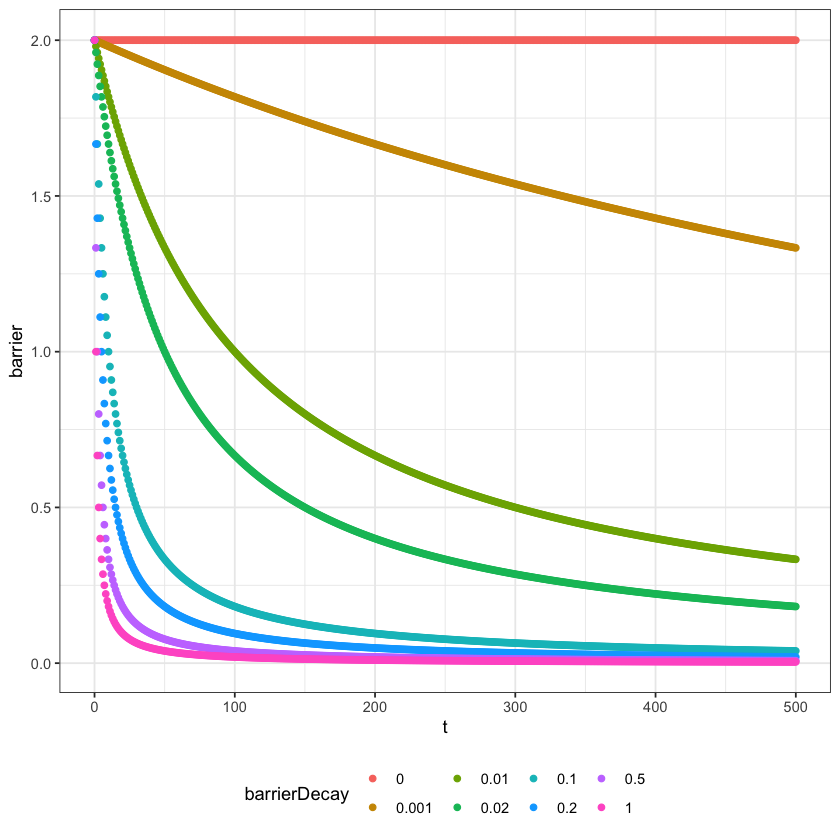

In [7]:
decay_vals = c(0, .001, .01, .02, .1, .2, .5, 1)

maxIter = 500

dat = data.frame()

for(cur_dv in decay_vals){
  cur_dat = data.frame(t = c(0:maxIter),
                       initialBarrier = 2, 
                       barrierDecay = cur_dv)
  
  cur_dat = cur_dat %>%
    mutate(barrier = initialBarrier / (1 + (barrierDecay * t)))
  
  dat = rbind(dat, cur_dat)
}

dat %>%
  mutate(barrierDecay = factor(barrierDecay, levels = decay_vals)) %>%
  ggplot(aes(t, barrier, color = barrierDecay))+
  geom_point()+
  theme_bw()+
  theme(legend.position = "bottom")

In [8]:
dat %>%
  filter(barrierDecay == .5) %>%
  arrange(-t)

t,initialBarrier,barrierDecay,barrier
<int>,<dbl>,<dbl>,<dbl>
500,2,0.5,0.007968127
499,2,0.5,0.007984032
498,2,0.5,0.008000000
497,2,0.5,0.008016032
496,2,0.5,0.008032129
495,2,0.5,0.008048290
494,2,0.5,0.008064516
493,2,0.5,0.008080808
492,2,0.5,0.008097166


In [ ]:
n = 10000

dat = data.frame(decay.alpha = rbeta(n, .1, 1), decay.beta = rgamma(n, 2, .5))
dat$decay.alpha = ifelse(dat$decay.alpha < 0, 0, ifelse(dat$decay.alpha > .5, .5, dat$decay.alpha))

for(i in 1:nrow(dat)){
  dat$decay[i] = rbeta(1, dat$decay.alpha[i], dat$decay.beta[i])
}

dat$decay = ifelse(dat$decay < 0, 0, ifelse(dat$decay > .5, .5, dat$decay))

dat %>%
  gather(key, value) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")


# Test trial simulation function

Simulate a few trials

In [9]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

In [22]:
cur_d = .03
cur_sigma = .02
cur_nonDecisionTime = 300 #ms
cur_bias = 0
# cur_barrierDecay = .002
cur_barrierDecay = 0

cur_valStim = .25
cur_valRef = 0
cur_valDiff = cur_valStim - cur_valRef

tmp = sim_trial(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, ValDiff = cur_valDiff, debug = T)

tmp

$out
  ValDiff choice reactionTime tooSlow tooFast    d sigma barrierDecay barrier
1    0.25    yes         1.76       0       0 0.03  0.02            0       1
  nonDecisionTime bias timeStep maxIter
1             300    0       10     400

$debug_df
    time    mu   RDV barrier
1      0    NA 0.000       1
2      1 0.000 0.033       1
3      2 0.000 0.018       1
4      3 0.000 0.019       1
5      4 0.000 0.037       1
6      5 0.000 0.075       1
7      6 0.000 0.055       1
8      7 0.000 0.094       1
9      8 0.000 0.102       1
10     9 0.000 0.149       1
11    10 0.000 0.145       1
12    11 0.000 0.153       1
13    12 0.000 0.153       1
14    13 0.000 0.134       1
15    14 0.000 0.147       1
16    15 0.000 0.160       1
17    16 0.000 0.148       1
18    17 0.000 0.183       1
19    18 0.000 0.185       1
20    19 0.000 0.176       1
21    20 0.000 0.181       1
22    21 0.000 0.172       1
23    22 0.000 0.171       1
24    23 0.000 0.165       1
25    24 0.000 0.183       1
26    25 0.000 0.218       1
27    26 0.000 0.231       1
28    27 0.000 0.222       1
29    28 0.000 0.210       1
30    29 0.000 0.226       1
31    30 0.000 0.222       1
32    31 0.007 0.223       1
33    32 0.007 0.228       1
34    33 0.007 0.222       1
35    34 0.007 0.243       1
36    35 0.007 0.261       1
37    36 0.007 0.277       1
38    37 0.007 0.255       1
39    38 0.007 0.263       1
40    39 0.007 0.301       1
41    40 0.007 0.300       1
42    41 0.007 0.320       1
43    42 0.007 0.366       1
44    43 0.007 0.385       1
45    44 0.007 0.367       1
46    45 0.007 0.325       1
47    46 0.007 0.336       1
48    47 0.007 0.376       1
49    48 0.007 0.357       1
50    49 0.007 0.367       1
51    50 0.007 0.358       1
52    51 0.007 0.389       1
53    52 0.007 0.394       1
54    53 0.007 0.404       1
55    54 0.007 0.403       1
56    55 0.007 0.393       1
57    56 0.007 0.425       1
58    57 0.007 0.455       1
59    58 0.007 0.450       1
60    59 0.007 0.458       1
61    60 0.007 0.472       1
62    61 0.007 0.456       1
63    62 0.007 0.468       1
64    63 0.007 0.472       1
65    64 0.007 0.468       1
66    65 0.007 0.453       1
67    66 0.007 0.452       1
68    67 0.007 0.439       1
69    68 0.007 0.447       1
70    69 0.007 0.436       1
71    70 0.007 0.438       1
72    71 0.007 0.422       1
73    72 0.007 0.434       1
74    73 0.007 0.438       1
75    74 0.007 0.458       1
76    75 0.007 0.451       1
77    76 0.007 0.449       1
78    77 0.007 0.486       1
79    78 0.007 0.506       1
80    79 0.007 0.488       1
81    80 0.007 0.485       1
82    81 0.007 0.483       1
83    82 0.007 0.506       1
84    83 0.007 0.517       1
85    84 0.007 0.514       1
86    85 0.007 0.497       1
87    86 0.007 0.474       1
88    87 0.007 0.467       1
89    88 0.007 0.496       1
90    89 0.007 0.517       1
91    90 0.007 0.536       1
92    91 0.007 0.566       1
93    92 0.007 0.587       1
94    93 0.007 0.599       1
95    94 0.007 0.606       1
96    95 0.007 0.608       1
97    96 0.007 0.600       1
98    97 0.007 0.613       1
99    98 0.007 0.597       1
100   99 0.007 0.565       1
101  100 0.007 0.520       1
102  101 0.007 0.591       1
103  102 0.007 0.578       1
104  103 0.007 0.563       1
105  104 0.007 0.566       1
106  105 0.007 0.565       1
107  106 0.007 0.563       1
108  107 0.007 0.574       1
109  108 0.007 0.573       1
110  109 0.007 0.573       1
111  110 0.007 0.567       1
112  111 0.007 0.561       1
113  112 0.007 0.549       1
114  113 0.007 0.544       1
115  114 0.007 0.556       1
116  115 0.007 0.544       1
117  116 0.007 0.571       1
118  117 0.007 0.552       1
119  118 0.007 0.573       1
120  119 0.007 0.595       1
121  120 0.007 0.574       1
122  121 0.007 0.551       1
123  122 0.007 0.551       1
124  123 0.007 0.583       1
125  124 0.007 0.553       1
126  125 0.007 0.556       1
127  126 0.007 0.580       1
128  127 0.007 0.595       1
129  12

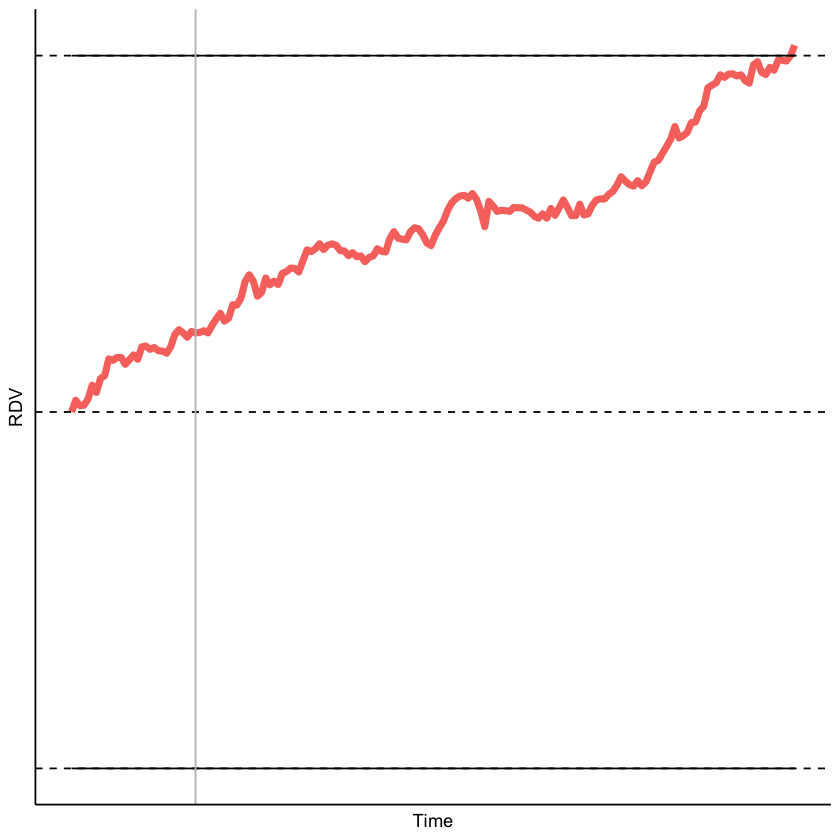

In [24]:
tmp$debug_df %>%
  ggplot()+
  geom_line(aes(time, RDV), color = "#F8766D", linewidth = 2) +
  geom_line(aes(time, barrier)) + 
  geom_line(aes(time, -barrier)) + 
  theme_classic() + 
  theme(axis.text = element_blank(),
        axis.ticks = element_blank(),) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  geom_hline(aes(yintercept = 1), linetype = "dashed") +
  geom_hline(aes(yintercept = -1), linetype = "dashed")+
  geom_vline(aes(xintercept = 30), color = "gray")+
  labs(x = "Time")

  ggsave(file=paste0(fig_out_path, 'sampleNoCollapsingBounds.png'), height = 3, width=5, units="in")

# Test task simulation function

In [25]:
source(paste0(helpers_path, '/ddm/sim_yn_ddm.R'))


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when




[1] "Make sure data has normVDiff column"


In [26]:
cur_d = .08
cur_sigma = .03
cur_nonDecisionTime = 200 #ms
cur_bias = 0
cur_barrierDecay = .008

sub_stims = data_yn_clean %>%
  filter((subnum == 611) & (day == 4) & (type == 1)) %>%
  filter(reference != -99) %>%
  filter(rt > .3 & rt < 2)

# names(sub_stims)

sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = sub_stims, model_name = "model1", sim_trial_list_ = sim_trial_list, d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, maxIter = 300, debug = T)

tmp



[1] "Simulating task with parameters: d = 0.08, sigma = 0.03, non-decision time = 200, bias = 0, barrierDecay = 0.008, maxIter = 300, timeStep = 10"


ValDiff,choice,reactionTime,tooSlow,tooFast,d,sigma,barrierDecay,barrier,nonDecisionTime,bias,timeStep,maxIter,model
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
-0.01675978,yes,1.34,0,0,0.08,0.03,0.008,0.4826255,200,0,10,300,model1
0.15083799,yes,0.58,0,0,0.08,0.03,0.008,0.6830601,200,0,10,300,model1
-0.71508380,no,0.36,0,0,0.08,0.03,0.008,0.7763975,200,0,10,300,model1
-0.35754190,no,0.53,0,0,0.08,0.03,0.008,0.7022472,200,0,10,300,model1
0.02793296,yes,0.82,0,0,0.08,0.03,0.008,0.6038647,200,0,10,300,model1
-0.41340782,no,0.46,0,0,0.08,0.03,0.008,0.7309942,200,0,10,300,model1
-0.03351955,no,2.51,0,0,0.08,0.03,0.008,0.3324468,200,0,10,300,model1
0.31843575,yes,0.47,0,0,0.08,0.03,0.008,0.7267442,200,0,10,300,model1
0.64804469,yes,0.31,0,0,0.08,0.03,0.008,0.8012821,200,0,10,300,model1


Are these reasonable parameter values?

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
i Please use `after_stat(density)` instead."


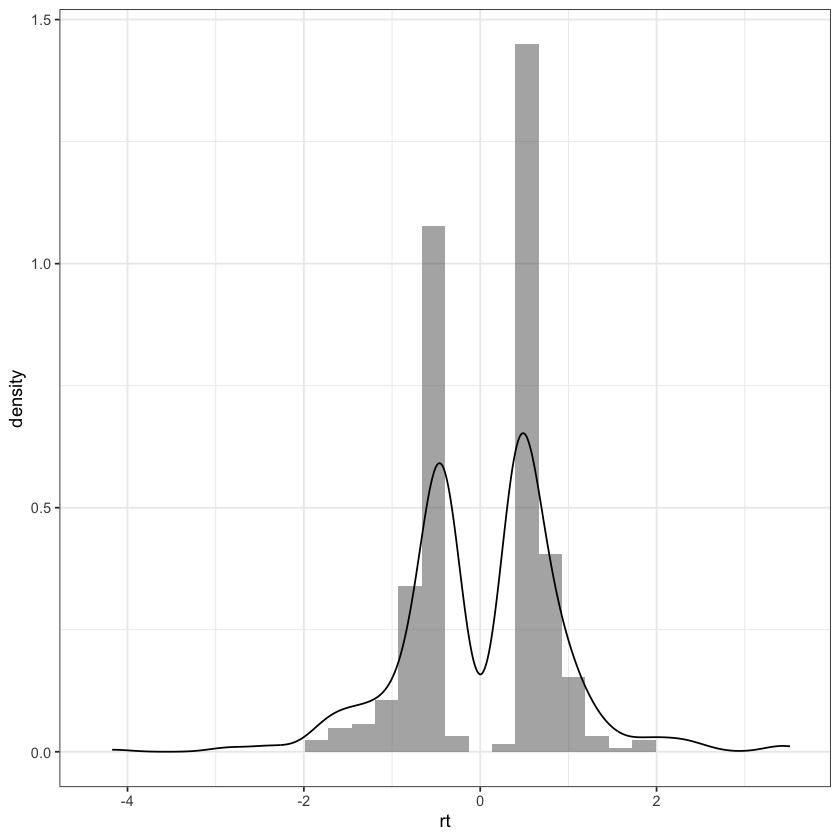

In [27]:
true_dat = sub_stims %>%
  ungroup() %>%
  select(yesChosen, rt) %>%
  mutate(rt = ifelse(yesChosen == 0, (-1) * rt, rt),
         data = "true")

sim_dat = tmp %>%
  select(choice, reactionTime) %>%
  mutate(yesChosen = ifelse(choice == "yes", 1, 0),
         rt = ifelse(choice == "yes", reactionTime, (-1) * reactionTime),
         data = "sim") %>%
  select(-choice, -reactionTime)

ggplot()+
  geom_histogram(data = true_dat, aes(rt, y = ..density..), bins = 30, alpha = 0.5)+
  geom_density(data = sim_dat, aes(rt))

# Test trial likelihood function

In [28]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

In [29]:
i = 25

tmp[i,]

,ValDiff,choice,reactionTime,tooSlow,tooFast,d,sigma,barrierDecay,barrier,nonDecisionTime,bias,timeStep,maxIter,model
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
25,-0.3407821,no,0.5,0,0,0.08,0.03,0.008,0.7142857,200,0,10,300,model1


In [30]:
fit_trial(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .1)

likelihood,ValDiff,choice,reactionTime,d,sigma,nonDecisionTime,bias,barrierDecay,barrier,timeStep
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.003858138,-0.3407821,-1,500,0.08,0.03,200,0,0.008,0.7183908,10


In [31]:
fit_trial(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .01)

likelihood,ValDiff,choice,reactionTime,d,sigma,nonDecisionTime,bias,barrierDecay,barrier,timeStep
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.05469567,-0.3407821,-1,500,0.08,0.03,200,0,0.008,0.7183908,10


**Note higher (and incorrect!) parameter has higher likelihood with large state step size!**

In [32]:
fit_trial(d = cur_d*10, sigma = cur_sigma*10, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .1)

likelihood,ValDiff,choice,reactionTime,d,sigma,nonDecisionTime,bias,barrierDecay,barrier,timeStep
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.25135e-08,-0.3407821,-1,500,0.8,0.3,200,0,0.008,0.7183908,10


In [33]:
fit_trial(d = cur_d*10, sigma = cur_sigma*10, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .01)

likelihood,ValDiff,choice,reactionTime,d,sigma,nonDecisionTime,bias,barrierDecay,barrier,timeStep
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.625974e-08,-0.3407821,-1,500,0.8,0.3,200,0,0.008,0.7183908,10


In [34]:
fit_trial(d = cur_d/2, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .01)

likelihood,ValDiff,choice,reactionTime,d,sigma,nonDecisionTime,bias,barrierDecay,barrier,timeStep
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01199863,-0.3407821,-1,500,0.04,0.03,200,0,0.008,0.7183908,10


## Debugging state space

In [35]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

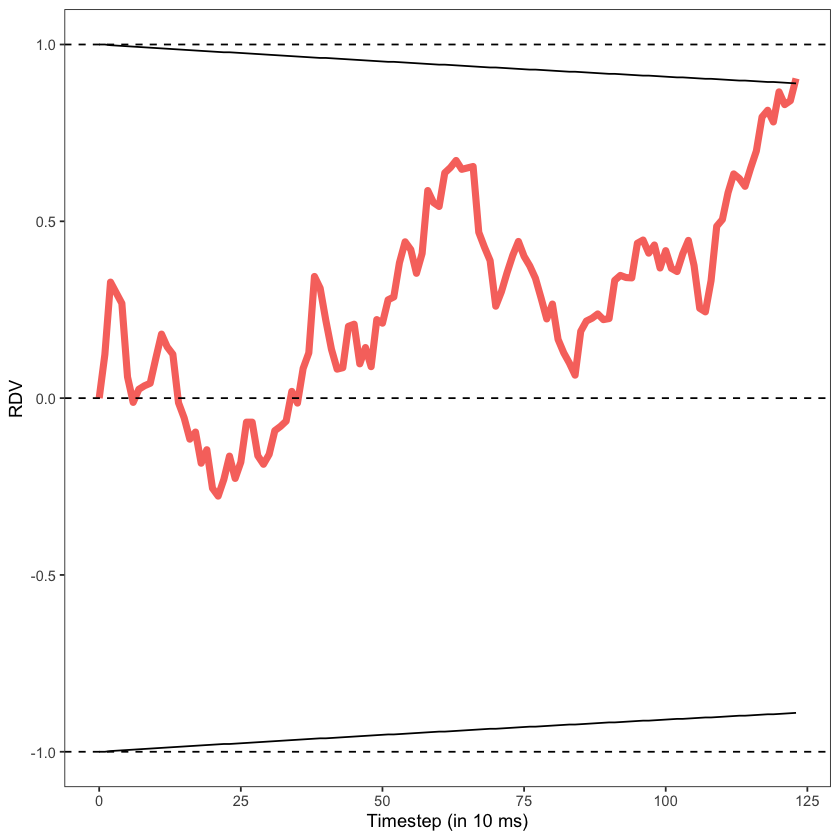

In [36]:
tmp = sim_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001, ValDiff = -1, debug = T)

tmp$debug_df %>%
  ggplot()+
  geom_line(aes(time, RDV), color = "#F8766D", size = 2)+
  geom_line(aes(time, barrier))+
  geom_line(aes(time, -barrier))+
  theme(panel.grid = element_blank())+
  geom_hline(aes(yintercept = 0), linetype = "dashed")+
  geom_hline(aes(yintercept = 1), linetype = "dashed")+
  geom_hline(aes(yintercept = -1), linetype = "dashed")+
  labs(x = "Timestep (in 10 ms)")

In [37]:
sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = tibble(normVDiff = rep(-1, 200)), model_name = "model1", sim_trial_list_ = sim_trial_list, d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001)

summary(tmp$reactionTime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.730   1.200   1.447   2.010   3.440 

In [38]:
debug_out = fit_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0, ValDiff = -1, choice = -1, reactionTime = 1.5, debug=T)

str(debug_out)

List of 6
 $ likelihood      : tibble [1 x 11] (S3: tbl_df/tbl/data.frame)
  ..$ likelihood     : num 0.00318
  ..$ ValDiff        : num -1
  ..$ choice         : num -1
  ..$ reactionTime   : num 1500
  ..$ d              : num 0.005
  ..$ sigma          : num 0.07
  ..$ nonDecisionTime: num 200
  ..$ bias           : num 0
  ..$ barrierDecay   : num 0
  ..$ barrier        : num 1
  ..$ timeStep       : num 10
 $ prStates        : num [1:201, 1:150] 0 0 0 0 0 0 0 0 0 0 ...
 $ probUpCrossing  : num [1:150] 0.00 0.00 2.56e-24 8.06e-17 4.57e-13 ...
 $ probDownCrossing: num [1:150] 0.00 1.34e-46 2.72e-24 8.06e-17 4.57e-13 ...
 $ renorm_debug    : tibble [149 x 6] (S3: tbl_df/tbl/data.frame)
  ..$ sumIn        : num [1:149] 1 1 1 1 1 ...
  ..$ sumCurrent   : num [1:149] 1 1 1 1 1 ...
  ..$ tempUpCross  : num [1:149] 0.00 2.56e-24 8.06e-17 4.57e-13 8.33e-11 ...
  ..$ tempDownCross: num [1:149] 1.34e-46 2.72e-24 8.06e-17 4.57e-13 8.33e-11 ...
  ..$ cumSumPUp    : num [1:149] 0.00 0.00 2.56e-

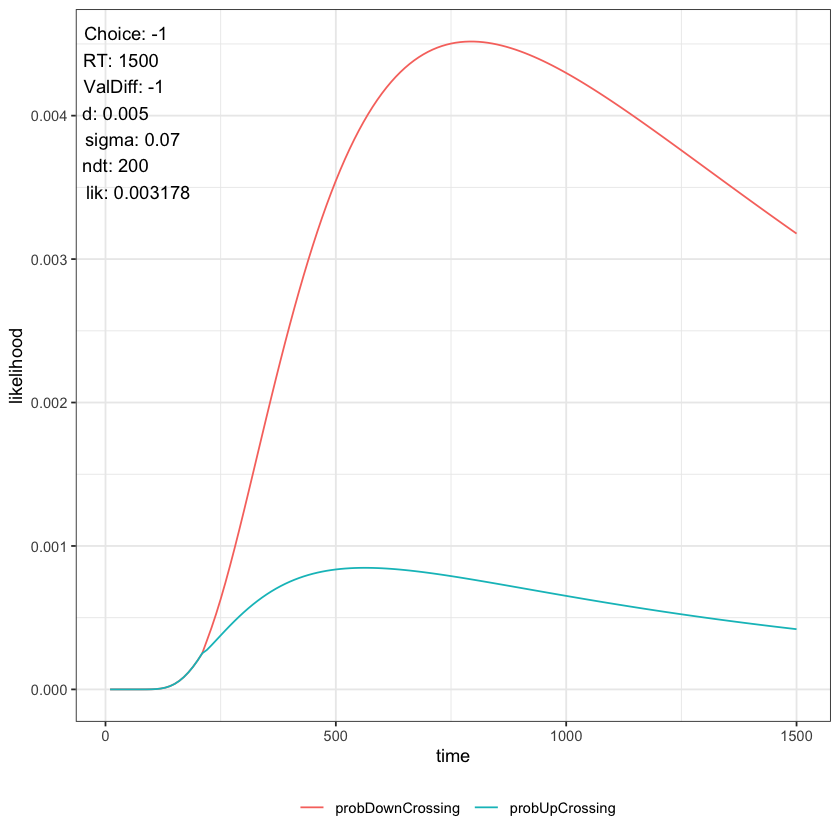

In [39]:
annotations <- data.frame(
        xpos = c(-Inf),
        ypos =  c(Inf),
        annotateText = c(paste0("Choice: ", debug_out$likelihood$choice,
                         "\nRT: ", debug_out$likelihood$reactionTime,
                         "\nValDiff: ", debug_out$likelihood$ValDiff,
                         "\nd: ", debug_out$likelihood$d,
                         "\nsigma: ", debug_out$likelihood$sigma,
                         "\nndt: ", debug_out$likelihood$nonDecisionTime,
                         "\nlik: ", round(debug_out$likelihood$likelihood, 6))),
        hjustvar = c(-0.1) ,
        vjustvar = c(1.1))

tibble(probUpCrossing = debug_out$probUpCrossing,
       probDownCrossing = debug_out$probDownCrossing) %>%
  mutate(time = 1:n() * (debug_out$likelihood$timeStep)) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "likelihood", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

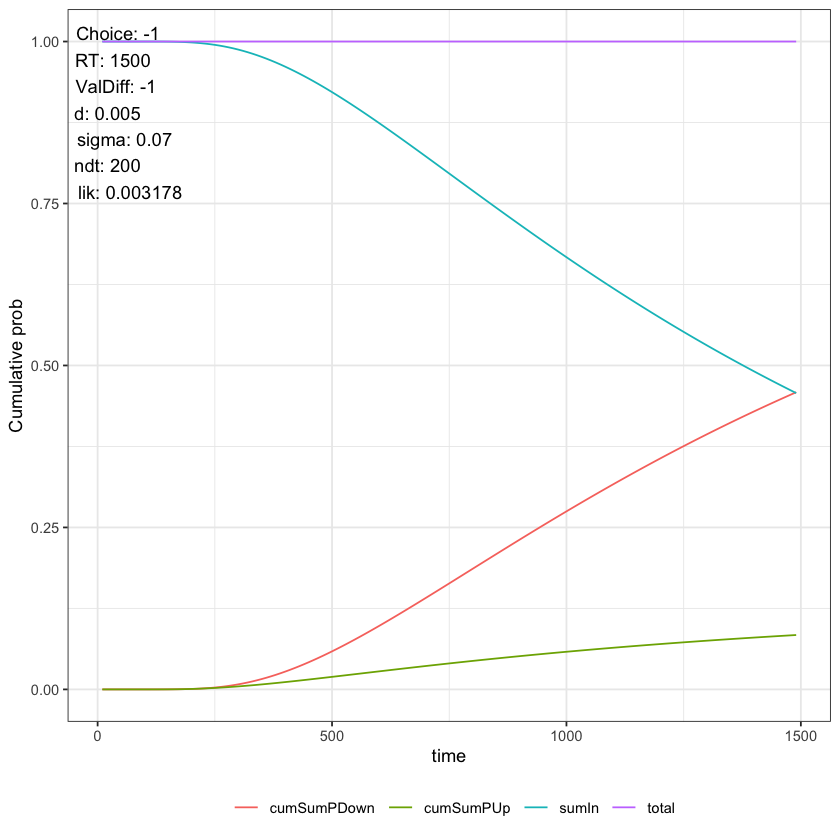

In [40]:
debug_out$renorm_debug %>%
  select(sumIn, cumSumPUp, cumSumPDown) %>%
  mutate(total = sumIn + cumSumPUp + cumSumPDown,
         time = 1:n() * debug_out$likelihood$timeStep) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "Cumulative prob", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))


What are these kinks in the distributions when there is decay in barriers?

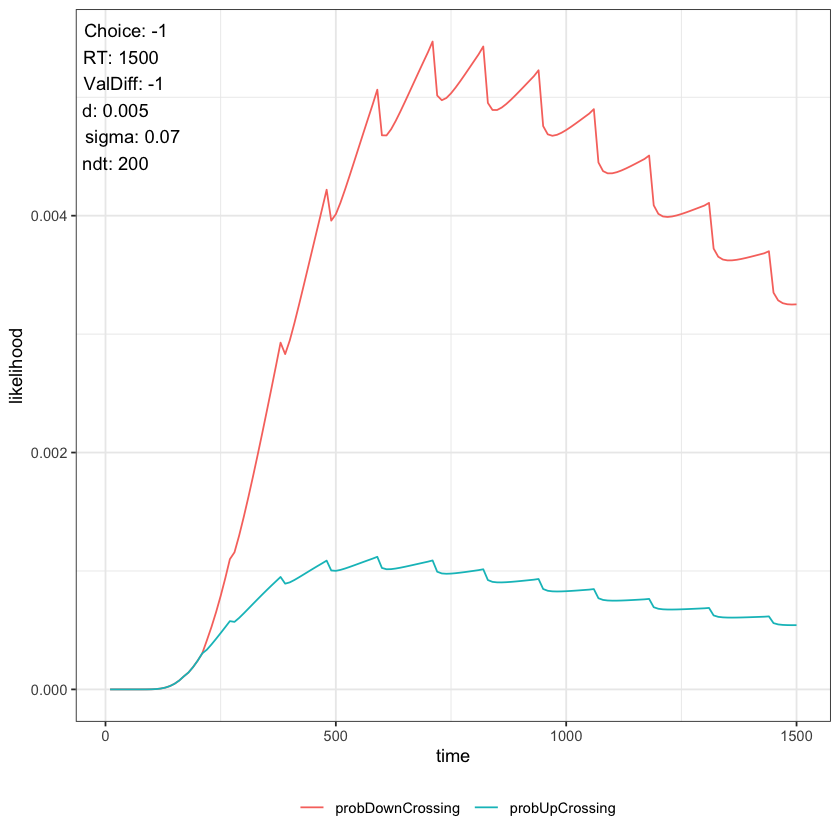

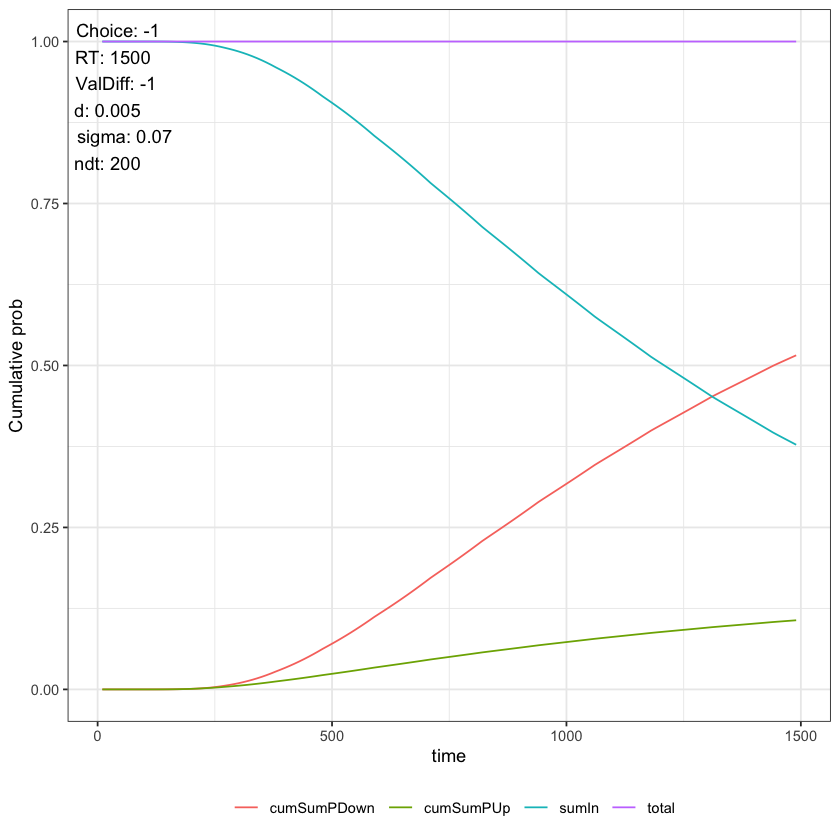

In [41]:
debug_out = fit_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001, ValDiff = -1, choice = -1, reactionTime = 1.5, debug=T)

annotations <- data.frame(
        xpos = c(-Inf),
        ypos =  c(Inf),
        annotateText = c(paste0("Choice: ", debug_out$likelihood$choice,
                         "\nRT: ", debug_out$likelihood$reactionTime,
                         "\nValDiff: ", debug_out$likelihood$ValDiff,
                         "\nd: ", debug_out$likelihood$d,
                         "\nsigma: ", debug_out$likelihood$sigma,
                         "\nndt: ", debug_out$likelihood$nonDecisionTime)),
        hjustvar = c(-0.1) ,
        vjustvar = c(1.1))

tibble(probUpCrossing = debug_out$probUpCrossing,
       probDownCrossing = debug_out$probDownCrossing) %>%
  mutate(time = 1:n() * (debug_out$likelihood$timeStep)) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "likelihood", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

debug_out$renorm_debug %>%
  select(sumIn, cumSumPUp, cumSumPDown) %>%
  mutate(total = sumIn + cumSumPUp + cumSumPDown,
         time = 1:n() * debug_out$likelihood$timeStep) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "Cumulative prob", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

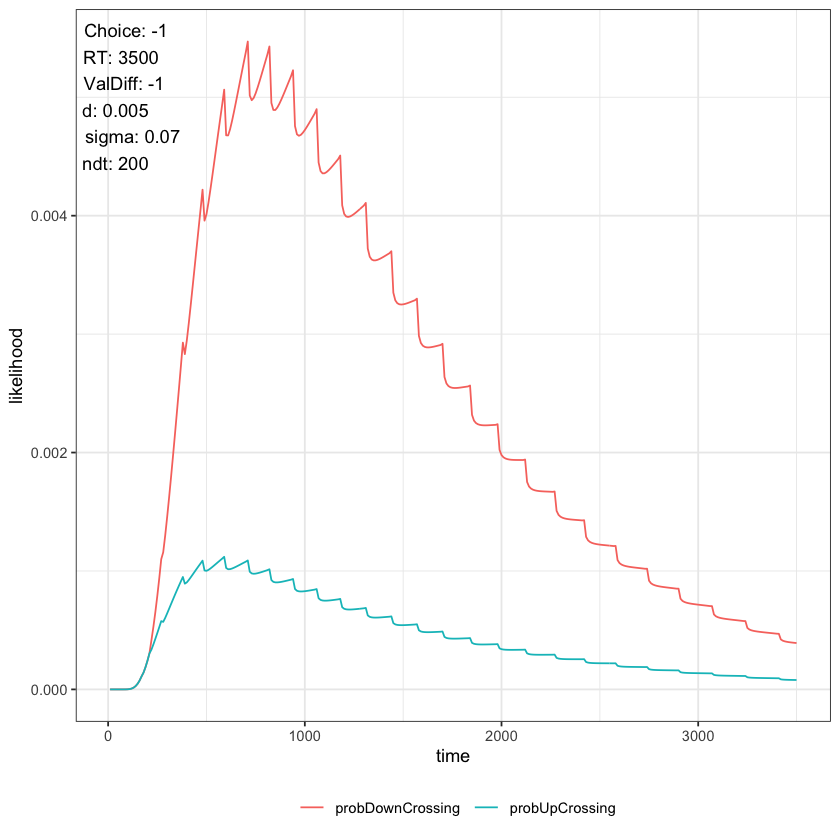

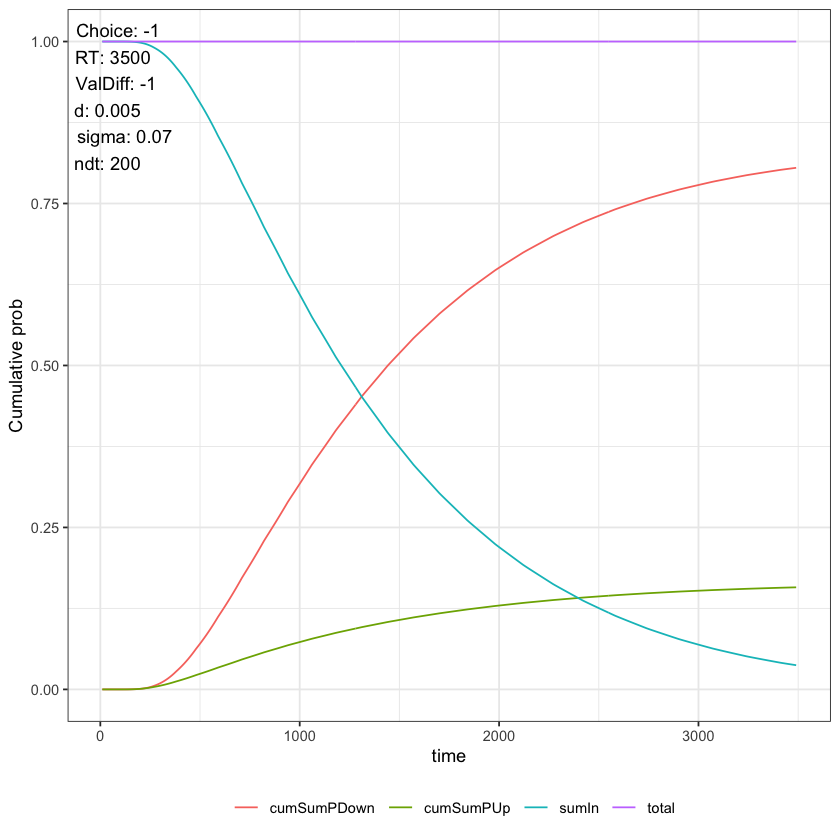

In [42]:
debug_out = fit_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001, ValDiff= -1, choice = -1, reactionTime = 3.5, debug=T)

annotations <- data.frame(
        xpos = c(-Inf),
        ypos =  c(Inf),
        annotateText = c(paste0("Choice: ", debug_out$likelihood$choice,
                         "\nRT: ", debug_out$likelihood$reactionTime,
                         "\nValDiff: ", debug_out$likelihood$ValDiff,
                         "\nd: ", debug_out$likelihood$d,
                         "\nsigma: ", debug_out$likelihood$sigma,
                         "\nndt: ", debug_out$likelihood$nonDecisionTime)),
        hjustvar = c(-0.1) ,
        vjustvar = c(1.1))

tibble(probUpCrossing = debug_out$probUpCrossing,
       probDownCrossing = debug_out$probDownCrossing) %>%
  mutate(time = 1:n() * (debug_out$likelihood$timeStep)) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "likelihood", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

debug_out$renorm_debug %>%
  select(sumIn, cumSumPUp, cumSumPDown) %>%
  mutate(total = sumIn + cumSumPUp + cumSumPDown,
         time = 1:n() * debug_out$likelihood$timeStep) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "Cumulative prob", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

# Test task fitting functions

In [43]:
source(paste0(helpers_path, '/ddm/fit_yn_ddm.R'))

In [44]:
cur_d = .03
cur_sigma = .02
cur_nonDecisionTime = 300 #ms
cur_bias = 0
cur_barrierDecay = .002

In [45]:
sub_stims = data_yn_clean %>%
  filter((subnum == 611) & (day == 4) & (type == 1))

# names(sub_stims)

sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = sub_stims, model_name = "model1", sim_trial_list_ = sim_trial_list, d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, debug = T)

tmp

[1] "Simulating task with parameters: d = 0.03, sigma = 0.02, non-decision time = 300, bias = 0, barrierDecay = 0.002, maxIter = 400, timeStep = 10"


ValDiff,choice,reactionTime,tooSlow,tooFast,d,sigma,barrierDecay,barrier,nonDecisionTime,bias,timeStep,maxIter,model
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
-0.01675978,no,3.466808,1,0,0.03,0.02,0.002,0.5555556,300,0,10,400,model1
0.15083799,yes,1.900000,0,0,0.03,0.02,0.002,0.7246377,300,0,10,400,model1
-0.14525140,no,1.800000,0,0,0.03,0.02,0.002,0.7352941,300,0,10,400,model1
-0.71508380,no,0.770000,0,0,0.03,0.02,0.002,0.8665511,300,0,10,400,model1
-0.35754190,no,1.090000,0,0,0.03,0.02,0.002,0.8210181,300,0,10,400,model1
0.02793296,yes,3.466808,1,0,0.03,0.02,0.002,0.5555556,300,0,10,400,model1
-0.41340782,no,1.000000,0,0,0.03,0.02,0.002,0.8333333,300,0,10,400,model1
-0.03351955,no,3.175387,1,0,0.03,0.02,0.002,0.5555556,300,0,10,400,model1
0.31843575,yes,1.050000,0,0,0.03,0.02,0.002,0.8264463,300,0,10,400,model1


In [46]:
fit_trial_list = list("model1" = fit_trial)

fit_task(data_ = tmp[1:100,], model_name_ = "model1", pars_ = list(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay) , fit_trial_list_ = fit_trial_list, debug=FALSE)

likelihood,ValDiff,choice,reactionTime,d,sigma,nonDecisionTime,bias,barrierDecay,barrier,timeStep
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.001276738,-0.01675978,-1,3466.808,0.03,0.02,300,0,0.002,0.5917160,10
0.010024913,0.15083799,1,1900.000,0.03,0.02,300,0,0.002,0.7256894,10
0.009735591,-0.14525140,-1,1800.000,0.03,0.02,300,0,0.002,0.7363770,10
0.042463977,-0.71508380,-1,770.000,0.03,0.02,300,0,0.002,0.8680556,10
0.020462642,-0.35754190,-1,1090.000,0.03,0.02,300,0,0.002,0.8223684,10
0.001743120,0.02793296,1,3466.808,0.03,0.02,300,0,0.002,0.5917160,10
0.032689204,-0.41340782,-1,1000.000,0.03,0.02,300,0,0.002,0.8347245,10
0.001867435,-0.03351955,-1,3175.387,0.03,0.02,300,0,0.002,0.6127451,10
0.020161133,0.31843575,1,1050.000,0.03,0.02,300,0,0.002,0.8278146,10


Is negative log likelihood lower for the true parameter combination compared to other combinations?

In [47]:
get_task_nll(data_ = tmp[1:100,], par_ = c(cur_d, cur_sigma, cur_nonDecisionTime, cur_bias, cur_barrierDecay), par_names_ = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"), model_name_ = "model1")

[1] 498.693

In [48]:
get_task_nll(data_ = tmp[1:100,], par_ = c(cur_d/2, cur_sigma, cur_nonDecisionTime, cur_bias, cur_barrierDecay), par_names_ = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"), model_name_ = "model1")

[1] 642.1235

In [49]:
get_task_nll(data_ = tmp[1:100,], par_ = c(cur_d, cur_sigma/2, cur_nonDecisionTime, cur_bias, cur_barrierDecay), par_names_ = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"), model_name_ = "model1")

[1] 611.2115

## Test optim on simulated data

In [50]:
cur_d = .03
cur_sigma = .02
cur_nonDecisionTime = 300 #ms
cur_bias = 0
cur_barrierDecay = .002

In [51]:
sub_stims = data_yn_clean %>%
  filter((subnum == 611) & (day == 4) & (type == 1))

sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = sub_stims, model_name = "model1", sim_trial_list_ = sim_trial_list, d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, debug = T)

[1] "Simulating task with parameters: d = 0.03, sigma = 0.02, non-decision time = 300, bias = 0, barrierDecay = 0.002, maxIter = 400, timeStep = 10"


In [52]:
start_vals = c(.01, .01, 100, 0, .001)
par_names = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay")
model = 'model1'

optim_out = optim(par = start_vals, get_task_nll, data_= tmp, par_names_ = par_names, model_name_ = model, control = list(maxit = 5, trace = 2))

cur_out = tibble(key = par_names, value = optim_out$par)
cur_out = cur_out %>% spread(key, value)
cur_out$nll = optim_out$value

cur_out

  Nelder-Mead direct search function minimizer
function value for initial parameters = 8072.814335
  Scaled convergence tolerance is 0.000120294
Stepsize computed as 10.000000
BUILD              6 217918.260200 8072.814335
Exiting from Nelder Mead minimizer
    8 function evaluations used


barrierDecay,bias,d,nonDecisionTime,sigma,nll
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.001,0,0.01,100,0.01,8072.814


## Test optim on single subject

# Examine optim output for a single subject

Read in the estimates for a single subject:

In [ ]:
cur_sub = 601

all_files = list.files(path = paste0(here(), '/inputs/'), pattern= paste0("optim_YN_DDM_FIT_sub-",cur_sub))

optim_out= data.frame()

for (cur_file in all_files){
  cur_in = read.csv(paste0(here(), '/inputs/', cur_file))
  optim_out = rbind(optim_out, cur_in)
}

optim_out

Distribution of estimates

In [ ]:
optim_out %>%
  select(d, sigma, nonDecisionTime, bias, barrierDecay) %>%
  gather(key, value) %>%
  ggplot(aes(value, fill = key))+
  geom_histogram(bins = 30, alpha = .5)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "none",
        panel.grid = element_blank())

In [ ]:
p = optim_out %>%
  select(d, sigma, nonDecisionTime, bias, barrierDecay, day, type) %>%
  gather(key, value, -day, -type) %>%
  group_by(key, day, type) %>%
  summarise(mean_par = mean(value), 
            sem_par = sd(value)/sqrt(n()), .groups = "keep") %>%
  mutate(type = ifelse(type == 1, "HT", "RE"),
         key = factor(key, levels = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"))) %>%
  ggplot(aes(day, mean_par, color = type))+
  geom_point(position = position_dodge(width=.5))+
  geom_errorbar(aes(ymin = mean_par - sem_par, ymax = mean_par + sem_par), width = .1, position = position_dodge(width=.5)) +
  facet_wrap(~key, scales = "free", ncol = 5) +
  theme(legend.position = "bottom",
        panel.grid.minor = element_blank())+
  scale_color_brewer(palette = "Dark2")+
  labs(y = "", color = "")+
  scale_x_continuous(breaks = seq(1:11))

ggsave(file=paste0(fig_out_path, 'yn_sub-',cur_sub,'_optimDDMparsOverDays.jpg'), p, height = 4, width=12, units="in")


Correlation between estimates

In [ ]:
# Average correlation across days of HT

cor_mats = list()
for(cur_day in c(1:11)){
  cor_dt = optim_out %>%
    filter((type == 1) & (day == cur_day)) %>%
    select(d, sigma, nonDecisionTime, bias, barrierDecay)
  
  cor_mats[[cur_day]] = cor(cor_dt)
  
  
}

mean_cor_mat = Reduce("+", cor_mats) / length(cor_mats)
tg = tableGrob(round(mean_cor_mat, 3) )
ggsave(paste0(fig_out_path, "sub-",cur_sub, "_ddmOptimHTparCors.jpg"), tg, width = 12, height = 4)

In [ ]:
# Average correlation across days of HT

cor_mats = list()
for(cur_day in c(1:11)){
  cor_dt = optim_out %>%
    filter((type == 0) & (day == cur_day)) %>%
    select(d, sigma, nonDecisionTime, bias, barrierDecay)
  
  cor_mats[[cur_day]] = cor(cor_dt)
  
  
}

mean_cor_mat = Reduce("+", cor_mats) / length(cor_mats)
tg = tableGrob(round(mean_cor_mat, 3) )
ggsave(paste0(fig_out_path, "sub-",cur_sub, "_ddmOptimREparCors.jpg"), tg, width = 12, height = 4)

Correlation between each parameter and its starting point

In [ ]:
optim_out %>%
  ggplot(aes(start_d, d))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_sigma, sigma))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_nonDecisionTime, nonDecisionTime))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_bias, bias))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_barrierDecay, barrierDecay))+
  geom_point(size = 1)

In [ ]:
optim_out %>%
  select(d, start_d)

optim_out %>%
  select(sigma, start_sigma)

optim_out %>%
  select(nonDecisionTime, start_nonDecisionTime)

optim_out %>%
  select(bias, start_bias)

optim_out %>%
  select(barrierDecay, start_barrierDecay)

In [ ]:
optim_out %>%
  mutate(diff_d = abs(d - start_d),
         diff_sigma = abs(sigma - start_sigma),
         diff_bias = abs(bias - start_bias),
         diff_nonDecisionTime = abs(nonDecisionTime - start_nonDecisionTime),
         diff_barrierDecay = abs(barrierDecay - start_barrierDecay)) %>%
  select(diff_d, diff_sigma, diff_bias, diff_nonDecisionTime, diff_barrierDecay) %>%
  gather(key, value) %>%
  select(value) %>%
  distinct()

Posterior predictive data

In [ ]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

Checks of stylized behavioral effects